In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/german_credit_data.csv")

The first column of this dataframe is a copy of the index. This is already included in the dataframe, so we can remove it:

In [3]:
df = df.drop(columns = ['Unnamed: 0'], axis = 1)

# EDA

In [4]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


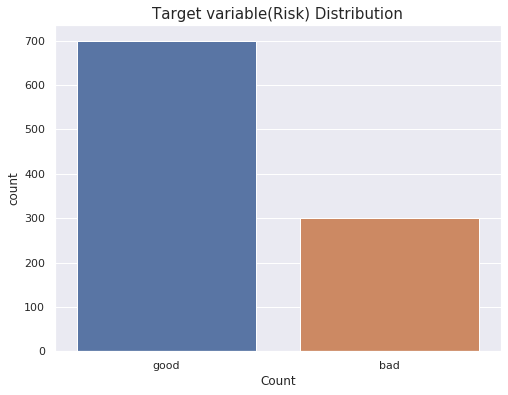

In [5]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="Risk",data= df)                  
g1.set_title("Target variable(Risk) Distribution", fontsize=15)
g1.set_xlabel("Risk")
g1.set_xlabel("Count")
plt.show()

In [6]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

The feature 'sex' only has 2 values. Which value should be considered base case when binary encoding is used?

In [7]:
total = df.shape[0]

male_count = df["Sex"].value_counts()[0]
female_count = df["Sex"].value_counts()[1]

print(str(100 * male_count/total) +  "% of instances describe males while " + str(100 * female_count/total) + "% of instances describe females.")

69.0% of instances describe males while 31.0% of instances describe females.


Male will be the base case, as females are less common.

# Data Preparation

In [8]:
df['Saving accounts'] = df['Saving accounts'].fillna('Missing')
df['Checking account'] = df['Checking account'].fillna('Missing')

In [9]:
tempDf = pd.get_dummies(df.drop(columns= ['Risk'],axis=1), drop_first=False)
tempDf['Risk'] = df['Risk']

df = tempDf

In [10]:
df['Risk'] = df['Risk'].replace('good', 1)
df['Risk'] = df['Risk'].replace('bad', 0)

In [11]:
# Considering males as base case, encoding females = 1

df = df.drop(columns = ['Sex_male'], axis = 1)

In [12]:
df

,Age,Job,Credit amount,Duration,Sex_female,Housing_free,Housing_own,Housing_rent,Saving accounts_Missing,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,67,2,1169,6,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,22,2,5951,48,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,49,1,2096,12,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,45,2,7882,42,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,53,2,4870,24,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1736,12,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
996,40,3,3857,30,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
997,38,2,804,12,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
998,23,2,1845,45,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state = 0)

outputVar = 'Risk'

X_train = train.drop(columns= [outputVar],axis=1)
y_train = train[outputVar]

X_test = test.drop(columns= [outputVar],axis=1)
y_test = test[outputVar]

## Decision Tree

### Vanilla Performance

In [14]:
from sklearn.tree import DecisionTreeClassifier

decTree = DecisionTreeClassifier(random_state=0)
decTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(decTree, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      '.\n')

The cross-validation-score of this classifier is 0.6381201298701298.



In [16]:
from sklearn.metrics import roc_auc_score

y_pred = decTree.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      '.\n')

The cross-validation-score of this classifier is 0.6056338028169015.



### Optimization

In [17]:
import skopt

The parameter tuning algorithm we are utilizing is called 'Bayesian Hyperparameter Optimization'. 

This algorithm firstly randomly picks combinations of parameters and then evaluates the score of the classifier with the given parameters - in our case, the score will be the ROC AUC. Then, based on the given scores, an approximation of the objective function is created. The objective function takes the parameters of the model as an input, and returns the classifier performance as an output. Our estimation of this function is called 'posterior function'.

This posterior function is updated iteratively by sampling new combinations of parameters. These are chosen using an 'acquisition function' which calculates areas of uncertainty in the posterior function. Here,  exploration and exploitation of the objective function are balanced. This means that combinations of parameters are sampled globally, to understand the overall shape of the objective function, but also locally at points of interest, to find the exact parameters that give the best result.

After a given number of samples, the best parameters according to the updated posterior function are returned.

In [18]:
from skopt.space import Integer, Categorical, Real
num_features = len(X_train.columns)
space = [Integer(1, 4,name='max_depth'),
        Integer(1, 100, name='min_samples_leaf'),
        Integer(2, 100, name='min_samples_split'),
        Real(0.0, 1, name='ccp_alpha')
]

In [19]:
from skopt.utils import use_named_args

myRandom = 0
@use_named_args(space)
def objective(**params):
  tempTree = DecisionTreeClassifier(**params, random_state = 0)
  global myRandom
  # Make 10 stratified shuffled folds using our random seed.
  myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=myRandom)
  # Score the tree
  scores = cross_val_score(tempTree, X_train, y_train, scoring = 'roc_auc', cv = myCV)
  # Update the random seed.
  myRandom = myRandom + 1
  result = scores.mean()
  # The optimization algorithm minimizes the score, so we have to negate it.
  return -result

In [20]:
from skopt import gp_minimize

opt = gp_minimize(objective, space, n_calls=150, random_state=0, verbose = False, n_jobs = -1)

In [21]:
opt.x

[4, 100, 100, 0.0]

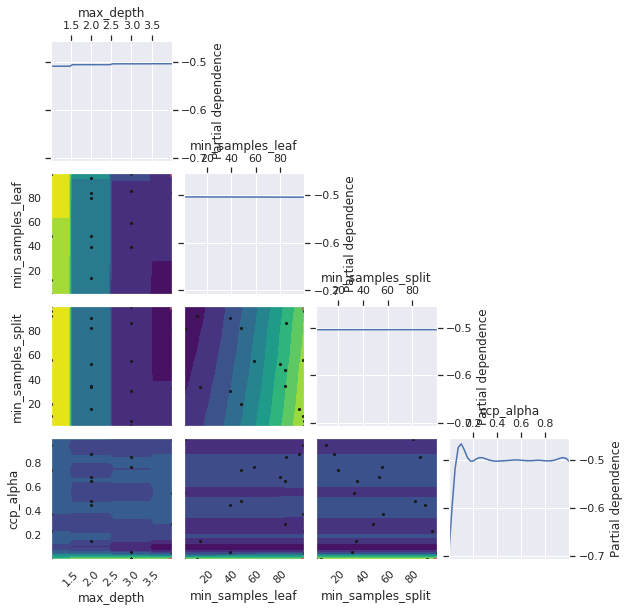

In [22]:
from skopt.plots import plot_objective

_ = plot_objective(opt)

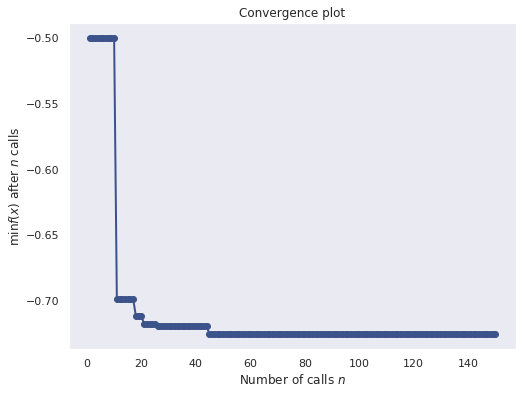

In [23]:
from skopt.plots import plot_convergence

_ = plot_convergence(opt)

In [24]:
optTree = DecisionTreeClassifier(max_depth = opt.x[0],
                                 min_samples_leaf = opt.x[1],
                                 min_samples_split = opt.x[2],
                                 ccp_alpha = opt.x[3],
                                 random_state = 0
                                 )

_ = optTree.fit(X_train, y_train)

In [25]:
myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(optTree, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      '.\n')

The cross-validation-score of this classifier is 0.7115876893939393.



In [26]:
y_pred = optTree.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      '.\n')

The cross-validation-score of this classifier is 0.6651287032540069.



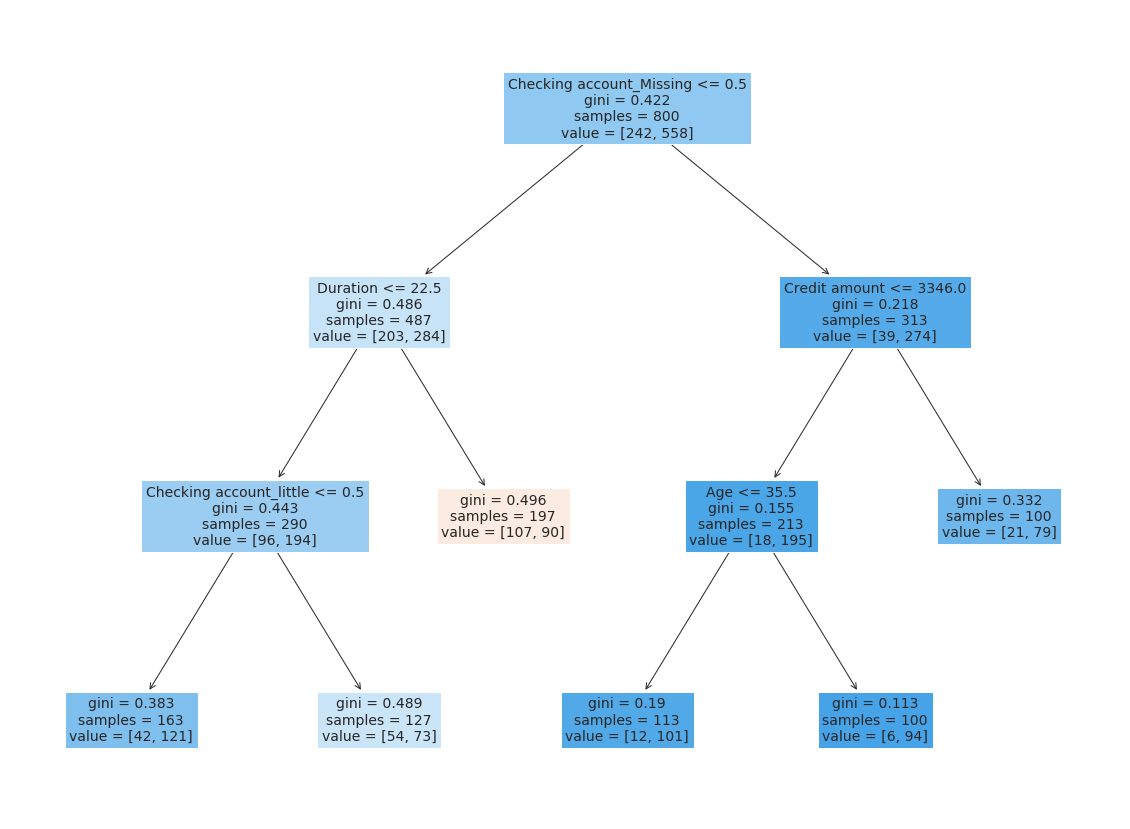

In [27]:
from sklearn import tree

fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(optTree,
                   feature_names = X_train.keys(),
                   filled=True)
